# Predicting High-Performance Social Posts (Binary) — Periospot

**Question:** Using only **pre-posting** signals, can we predict if a post will be a **High Performer**?  

**Decisions:** Threshold chosen empirically during EDA; Tree ensembles (RF/XGBoost) as main tuned family.  

**Anti-leakage:** No post-outcome columns (impressions/engagements/reach) in features.


In [65]:
# TODO: imports
import pandas as pd, numpy as np
from pathlib import Path
import sys
sys.path.append("..")  # or use the relative path to where 'src' is located
from src import features, labeling, evaluation, utils

# TODO: define paths
ROOT = Path("..").resolve().parent / "periospot_ml_social_media_performance"
RAW = ROOT / "data" / "raw"
ART = ROOT / "artifacts"
# HINT: ensure ART exists
ART.mkdir(parents=True, exist_ok=True)


## Load Data & Initial Checks

We load post-level data. We'll inspect columns, NA rates, and confirm which columns are "pre-posting" vs "post-outcome".


In [66]:
# Load raw post performance CSV
df = pd.read_csv(RAW / "post_performance.csv", low_memory=False)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nTotal columns: {len(df.columns)}")

# Show the TOP 30 columns with HIGHEST missing rates (we just saw these - mostly video/platform-specific)
print("\n=== TOP 80 HIGHEST MISSING RATES (Expected - Platform/Content Specific) ===")
print(df.isna().mean().sort_values(ascending=False).head(70))

# Now let's see the USEFUL columns (LOW missing rates)
print("\n=== COLUMNS WITH <10% MISSING (The Useful Ones!) ===")
low_missing = df.isna().mean().sort_values()
print(low_missing[low_missing < 0.10])
print("Total number of features:", len(df.columns))


Dataset shape: (8434, 67)
Date range: 1/1/2021 12:35 am to 9/9/2025 9:46 am

Total columns: 67

=== TOP 80 HIGHEST MISSING RATES (Expected - Platform/Content Specific) ===
Poll Votes                  1.000000
SproutLink Clicks           1.000000
Hashtag Video Views         1.000000
Organic Full Video Views    0.997629
Paid Partial Video Views    0.997629
                              ...   
Post ID                     0.000000
Profile                     0.000000
Sent by                     0.000000
Link                        0.000000
Date                        0.000000
Length: 67, dtype: float64

=== COLUMNS WITH <10% MISSING (The Useful Ones!) ===
Date            0.000000
Post ID         0.000000
Network         0.000000
Post Type       0.000000
Content Type    0.000000
Profile         0.000000
Sent by         0.000000
Link            0.000000
Post            0.027152
dtype: float64
Total number of features: 67


### Column Audit & Caption Coverage

Categorize features into **pre-posting** vs **post-outcome** buckets to guard against leakage, then inspect caption availability across networks/post types to confirm text-derived signals are viable.


In [67]:
# Categorize columns by type
all_cols = df.columns.tolist()

# PRE-POSTING FEATURES (Safe to use - known before publishing)
pre_posting_candidates = [
    'Date',           # When posted (time features)
    'Network',        # Which platform (X, Instagram, etc.)
    'Post Type',      # Type of post (photo, video, link, etc.)
    'Content Type',   # Content category
    'Profile',        # Which account posted
    'Post',           # Caption text (for text features: length, hashtags, etc.)
    'Permalink',      # URL (might extract domain info)
]

# POST-OUTCOME METRICS (LEAKAGE - these are results, not predictors!)
post_outcome_keywords = [
    'impression', 'reach', 'engagement', 'click', 'like', 'comment', 
    'share', 'save', 'view', 'follower', 'reaction', 'rate', 
    'video', 'watch', 'subscriber', 'playlist', 'card', 'annotation',
    'vote', 'sent', 'received'
]

# Identify columns
pre_posting_cols = [c for c in all_cols if any(p.lower() in c.lower() for p in ['date', 'network', 'post type', 'content type', 'profile', 'post', 'permalink']) and not any(k in c.lower() for k in post_outcome_keywords)]
post_outcome_cols = [c for c in all_cols if any(k in c.lower() for k in post_outcome_keywords)]
other_cols = [c for c in all_cols if c not in pre_posting_cols and c not in post_outcome_cols]

print("="*80)
print("✅ PRE-POSTING FEATURES (Safe to use):")
print("="*80)
for col in pre_posting_cols:
    print(f"  - {col} (NA: {df[col].isna().mean()*100:.1f}%)")

print("\n" + "="*80)
print("❌ POST-OUTCOME METRICS (Leakage - DO NOT use as predictors):")
print("="*80)
for col in post_outcome_cols:  # Show first 20
    print(f"  - {col} (NA: {df[col].isna().mean()*100:.1f}%)")


print("\n" + "="*80)
print("🤔 OTHER COLUMNS (Review these):")
print("="*80)
for col in other_cols:
    print(f"  - {col} (NA: {df[col].isna().mean()*100:.1f}%)")


✅ PRE-POSTING FEATURES (Safe to use):
  - Date (NA: 0.0%)
  - Post ID (NA: 0.0%)
  - Network (NA: 0.0%)
  - Post Type (NA: 0.0%)
  - Content Type (NA: 0.0%)
  - Profile (NA: 0.0%)
  - Post (NA: 2.7%)

❌ POST-OUTCOME METRICS (Leakage - DO NOT use as predictors):
  - Sent by (NA: 0.0%)
  - Impressions (NA: 46.6%)
  - Organic Impressions (NA: 57.2%)
  - Paid Impressions (NA: 99.0%)
  - Reach (NA: 93.2%)
  - Organic Reach (NA: 93.7%)
  - Paid Reach (NA: 99.0%)
  - Potential Reach (NA: 52.5%)
  - Engagement Rate (per Impression) (NA: 46.6%)
  - Engagements (NA: 44.0%)
  - Reactions (NA: 48.4%)
  - Likes (NA: 48.4%)
  - Dislikes (NA: 99.6%)
  - Love Reactions (NA: 99.0%)
  - Haha Reactions (NA: 99.0%)
  - Wow Reactions (NA: 99.0%)
  - Sad Reactions (NA: 99.0%)
  - Angry Reactions (NA: 99.0%)
  - Comments (NA: 44.0%)
  - Shares (NA: 46.2%)
  - Saves (NA: 99.1%)
  - Post Link Clicks (NA: 93.8%)
  - SproutLink Clicks (NA: 100.0%)
  - Other Post Clicks (NA: 62.4%)
  - Post Clicks (All) (NA: 62.6

In [68]:
legit_columns = ["Date", "Network", "Post Type", "Post", "Profile", "Content Type"]

nan_values_legit = df[legit_columns].isna().sum()/len(df) * 100 
print(nan_values_legit)

Date            0.0000
Network         0.0000
Post Type       0.0000
Post            2.7152
Profile         0.0000
Content Type    0.0000
dtype: float64


In [69]:
# Check: Which posts are missing captions?
missing_post = df[df['Post'].isna()]
print(f"Posts missing caption: {len(missing_post)}")
print(missing_post[['Date', 'Network', 'Post Type', 'Content Type']].value_counts())

Posts missing caption: 229
Date                Network    Post Type  Content Type
2/23/2025 7:33 am   Instagram  Story      Photo           5
                                          Video           4
12/20/2024 6:07 pm  Instagram  Story      Photo           2
12/2/2024 9:00 am   Instagram  Story      Photo           2
11/15/2024 2:48 pm  Instagram  Story      Photo           2
                                                         ..
12/27/2024 6:57 am  Instagram  Story      Photo           1
12/27/2024 7:19 pm  Instagram  Story      Photo           1
12/28/2024 9:00 pm  Instagram  Story      Photo           1
12/28/2024 9:18 pm  Instagram  Story      Photo           1
9/9/2025 10:02 am   Instagram  Story      Video           1
Name: count, Length: 219, dtype: int64


In [70]:
# 1. How many posts are missing captions?
missing_caption = df[df['Post'].isna()]
print(f"Missing captions: {len(missing_caption)} ({len(missing_caption)/len(df)*100:.2f}%)")

# 2. Is it related to Post Type?
print("\nMissing captions by Post Type:")
print(missing_caption['Post Type'].value_counts())

# 3. Is it related to Network?
print("\nMissing captions by Network:")
print(missing_caption['Network'].value_counts())

# 4. Compare to posts WITH captions - any pattern?
print("\nAll posts by Post Type:")
print(df['Post Type'].value_counts())

Missing captions: 229 (2.72%)

Missing captions by Post Type:
Post Type
Story    170
Post      57
Quote      1
Reel       1
Name: count, dtype: int64

Missing captions by Network:
Network
Instagram    172
Threads       44
YouTube        6
Facebook       6
X              1
Name: count, dtype: int64

All posts by Post Type:
Post Type
'@Reply    3958
Post       3621
Quote       435
Story       376
Reel         43
Pin           1
Name: count, dtype: int64


## Prepare Target Variable

Strip percentage symbols from `Engagement Rate (per Impression)`, cast to numeric, inspect coverage, and review sample rows before deciding how to binarize the outcome.


In [71]:
# Verify the target column exists and explore its distribution
target_col = "Engagement Rate (per Impression)"
assert target_col in df.columns, f"Column '{target_col}' not found!"
df[target_col] = df[target_col].str.strip("%")
df[target_col] = df[target_col].astype(float)

# Verify the conversion worked
print(f"Target column dtype: {df[target_col].dtype}")
print(f"Sample values after conversion:")
print(df[target_col].head(10))
print(f"\nAny conversion errors (NaN introduced)?")
print(f"NaN count: {df[target_col].isna().sum()}")


print("="*80)
print("TARGET VARIABLE ANALYSIS")
print("="*80)
print(f"\nTarget: {target_col}")
print(f"\nMissing rate: {df[target_col].isna().mean()*100:.2f}%")
print(f"\nBasic statistics:")
print(df[target_col].describe())

print(f"\nPercentiles:")
for p in [50, 75, 80, 85, 90, 95, 99]:
    val = df[target_col].quantile(p/100)
    print(f"  {p}th percentile: {val:.4f} ({100-p}% are above this = potential 'High Performers')")

# Show a few example rows with the pre-posting features
print("\n" + "="*80)
print("EXAMPLE ROWS (Pre-Posting Features + Target)")
print("="*80)
display_cols = ['Date', 'Network', 'Post Type', 'Content Type', 'Profile', target_col]
available_display = [c for c in display_cols if c in df.columns]
print(df[available_display].head(10))


Target column dtype: float64
Sample values after conversion:
0     1.68
1    13.20
2      NaN
3     2.43
4     2.04
5      NaN
6     5.97
7      NaN
8      NaN
9      NaN
Name: Engagement Rate (per Impression), dtype: float64

Any conversion errors (NaN introduced)?
NaN count: 3933
TARGET VARIABLE ANALYSIS

Target: Engagement Rate (per Impression)

Missing rate: 46.63%

Basic statistics:
count    4501.000000
mean        4.514168
std         8.025959
min         0.000000
25%         0.000000
50%         2.160000
75%         5.410000
max       200.000000
Name: Engagement Rate (per Impression), dtype: float64

Percentiles:
  50th percentile: 2.1600 (50% are above this = potential 'High Performers')
  75th percentile: 5.4100 (25% are above this = potential 'High Performers')
  80th percentile: 6.6700 (20% are above this = potential 'High Performers')
  85th percentile: 8.9600 (15% are above this = potential 'High Performers')
  90th percentile: 11.5400 (10% are above this = potential 'High

### Target Coverage Diagnostics

Quantify how often the engagement-rate target is populated overall and by network, post type, and posting year so we know where label gaps might appear.


In [72]:
# 1. Which rows have the target?
has_target = df[target_col].notna()
print(f"Rows WITH target: {has_target.sum()} ({has_target.sum()/len(df)*100:.1f}%)")
print(f"Rows WITHOUT target: {(~has_target).sum()} ({(~has_target).sum()/len(df)*100:.1f}%)")

# 2. Is it related to Network?
print("\nTarget availability by Network:")
print(df.groupby('Network')[target_col].apply(lambda x: x.notna().sum() / len(x) * 100))

# 3. Is it related to Post Type?
print("\nTarget availability by Post Type:")
print(df.groupby('Post Type')[target_col].apply(lambda x: x.notna().sum() / len(x) * 100))

# 4. Is it related to Date? (Maybe older posts don't have this metric?)
df['Year'] = pd.to_datetime(df['Date']).dt.year
print("\nTarget availability by Year:")
print(df.groupby('Year')[target_col].apply(lambda x: x.notna().sum() / len(x) * 100))

Rows WITH target: 4501 (53.4%)
Rows WITHOUT target: 3933 (46.6%)

Target availability by Network:
Network
Facebook     100.000000
Instagram     78.359511
LinkedIn      10.666667
Pinterest      0.000000
Threads       99.765533
TikTok       100.000000
X             45.253211
YouTube        0.000000
Name: Engagement Rate (per Impression), dtype: float64

Target availability by Post Type:
Post Type
'@Reply    49.949469
Pin         0.000000
Post       54.681027
Quote      29.655172
Reel       93.023256
Story      99.734043
Name: Engagement Rate (per Impression), dtype: float64


/var/folders/cd/2c6x3jgj47j_fwl7231ts7m00000gn/T/ipykernel_37515/3603389667.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Year'] = pd.to_datetime(df['Date']).dt.year



Target availability by Year:
Year
2020     0.342466
2021     0.070249
2022     1.809955
2023    35.222672
2024    96.007046
2025    97.846045
Name: Engagement Rate (per Impression), dtype: float64


In [73]:
# How much data do you have in 2024-2025?
df_2024_2025 = df[df['Year'].isin([2024, 2025])]
print(f"2024-2025 rows: {len(df_2024_2025)}")
print(f"Percentage of total: {len(df_2024_2025)/len(df)*100:.1f}%")

# How many posts per network in 2024-2025?
print("\nPosts per Network (2024-2025):")
print(df_2024_2025['Network'].value_counts())

print("\nNan values:")
print(df_2024_2025.isna().sum().head(20))

2024-2025 rows: 4535
Percentage of total: 53.8%

Posts per Network (2024-2025):
Network
X            3021
Threads       853
Instagram     439
Facebook       87
LinkedIn       75
TikTok         36
YouTube        23
Pinterest       1
Name: count, dtype: int64

Nan values:
Date                                   0
Post ID                                0
Network                                0
Post Type                              0
Content Type                           0
Profile                                0
Sent by                                0
Link                                   0
Post                                 226
Linked Content                      2739
Impressions                          128
Organic Impressions                 1018
Paid Impressions                    4451
Reach                               3974
Organic Reach                       4013
Paid Reach                          4451
Potential Reach                     2500
Engagement Rate (per Impression)

### Focus on 2024-2025 Window & Temporal Split Draft

Limit the dataset to 2024-2025 posts with a valid target, convert dates, and lay out train/validation/test slices while checking that impressions/target metrics stay aligned. Plot posts per month to confirm we have steady volume.


In [74]:
# Filter to 2024-2025 posts with target available
df_clean = df[(df['Year'].isin([2024, 2025])) & (df[target_col].notna())].copy()
df_clean['Date'] = pd.to_datetime(df_clean['Date'])

train_candidates = df_clean[df_clean['Year'] == 2024]
test_candidates = df_clean[df_clean['Year'] == 2025]
print(f"Training window candidates (2024): {len(train_candidates)} rows")
print(f"Hold-out window candidates (2025): {len(test_candidates)} rows")

train = df_clean[(df_clean['Year'] == 2024) & (df_clean['Date'] < '2024-10-01')]
val = df_clean[(df_clean['Year'] == 2024) & (df_clean['Date'] >= '2024-10-01')]
test = df_clean[df_clean['Year'] == 2025]

print("\nTemporal split proposal (train/val/test):")
print(f"  Train (2024 Jan-Sep): {len(train)} rows")
print(f"  Validation (2024 Oct-Dec): {len(val)} rows")
print(f"  Test (2025): {len(test)} rows")
print(f"  Train/Test ratio: {len(train)/(len(test) + 1e-9):.2f}")


Training window candidates (2024): 1635 rows
Hold-out window candidates (2025): 2771 rows

Temporal split proposal (train/val/test):
  Train (2024 Jan-Sep): 669 rows
  Validation (2024 Oct-Dec): 966 rows
  Test (2025): 2771 rows
  Train/Test ratio: 0.24


/var/folders/cd/2c6x3jgj47j_fwl7231ts7m00000gn/T/ipykernel_37515/4292711075.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean['Date'] = pd.to_datetime(df_clean['Date'])


In [75]:
# Are they the same rows?
no_impressions = df_clean[df_clean['Impressions'].isna()]
no_eng_rate = df_clean[df_clean[target_col].isna()]

print(f"Rows missing Impressions: {len(no_impressions)}")
print(f"Rows missing Eng Rate: {len(no_eng_rate)}")
print(f"Overlap: {len(no_impressions[no_impressions.index.isin(no_eng_rate.index)])}")

Rows missing Impressions: 0
Rows missing Eng Rate: 0
Overlap: 0


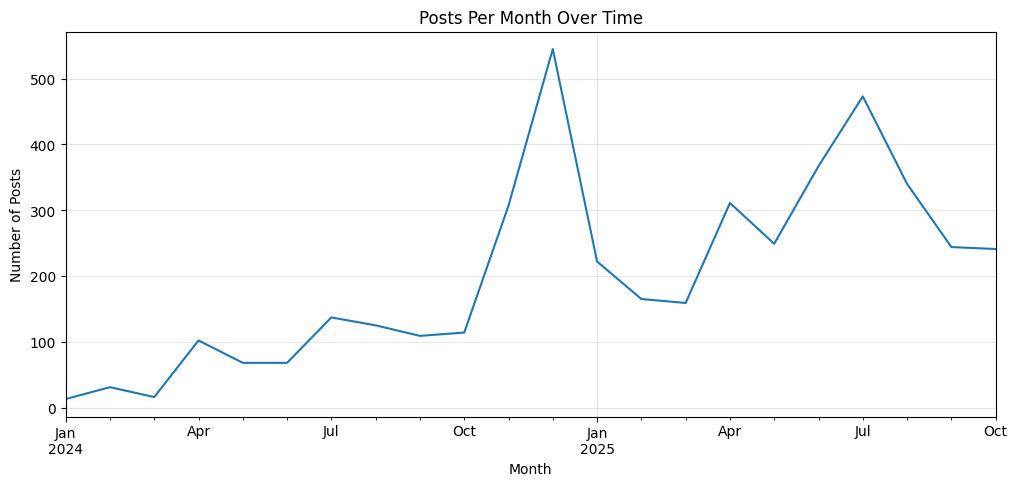


Posts per month:
YearMonth
2024-01     13
2024-02     31
2024-03     16
2024-04    102
2024-05     68
2024-06     68
2024-07    137
2024-08    125
2024-09    109
2024-10    114
2024-11    307
2024-12    545
2025-01    222
2025-02    165
2025-03    159
2025-04    311
2025-05    249
2025-06    367
2025-07    473
2025-08    340
2025-09    244
2025-10    241
Freq: M, dtype: int64


In [76]:
# Posts per month over time
df_clean['YearMonth'] = pd.to_datetime(df_clean['Date']).dt.to_period('M')
posts_per_month = df_clean.groupby('YearMonth').size()

import matplotlib.pyplot as plt
posts_per_month.plot(kind='line', figsize=(12, 5))
plt.title('Posts Per Month Over Time')
plt.ylabel('Number of Posts')
plt.xlabel('Month')
plt.grid(True, alpha=0.3)
plt.show()

print("\nPosts per month:")
print(posts_per_month)

### Target Distribution Visualization

Let's visualize the distribution to choose a defensible threshold for "High Performer".


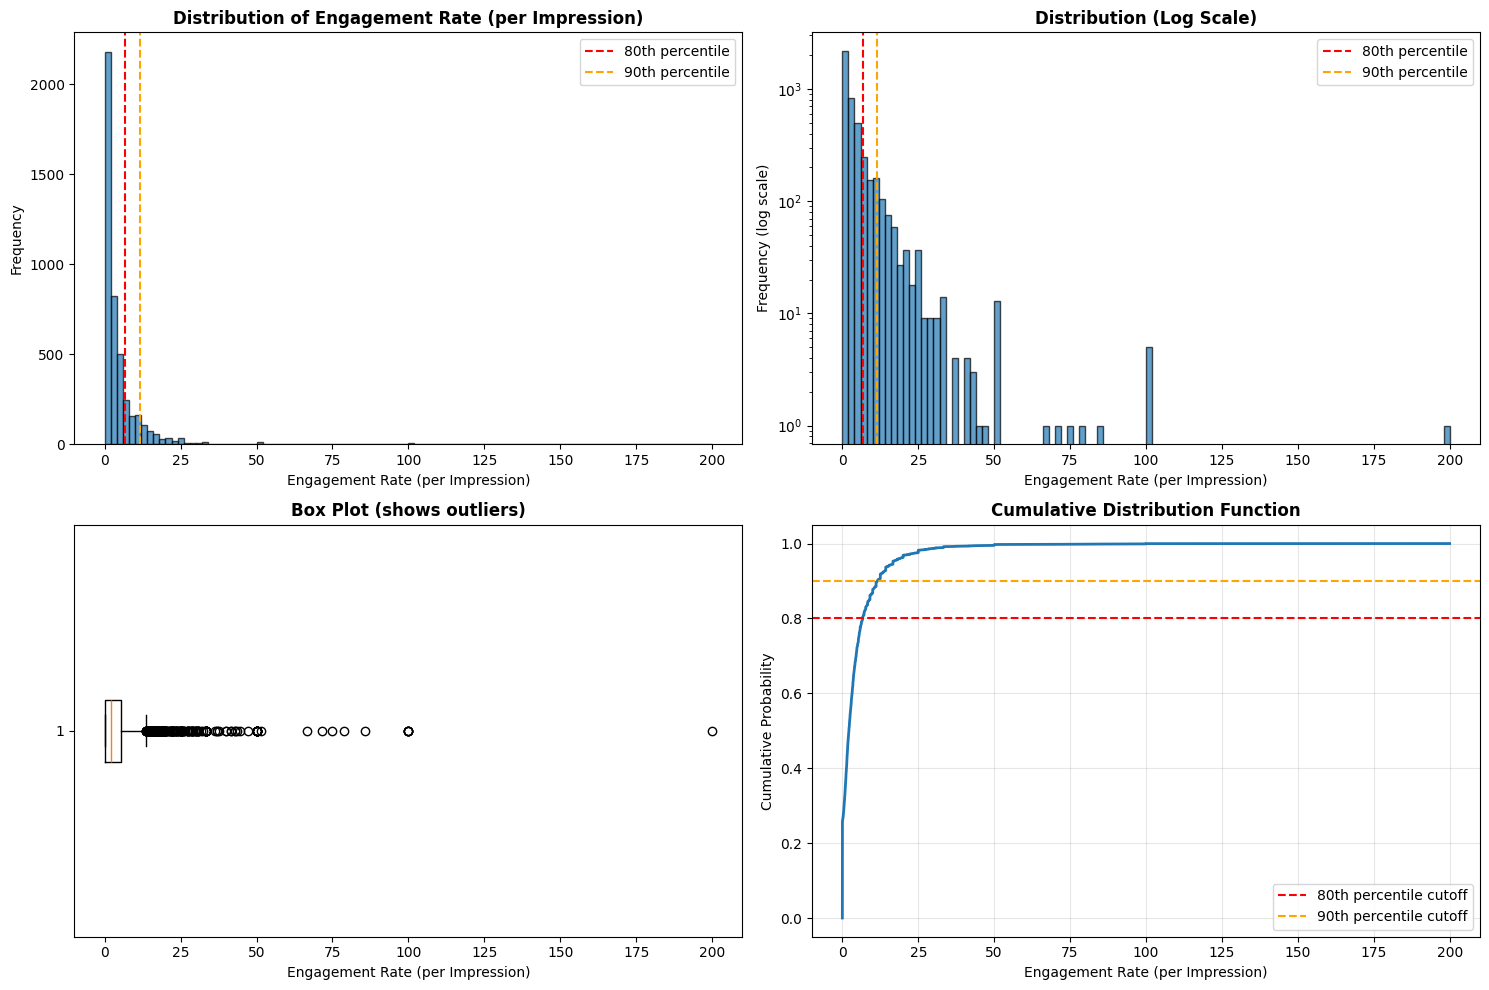


INTERPRETATION GUIDE

- Look at the distribution shape: Is it skewed? Are there outliers?
- Choose a percentile that separates 'High Performers' from 'Regular' posts
- Common choices:
  • 80th percentile = top 20% are "High Performers" (balanced)
  • 85th percentile = top 15% are "High Performers" (more selective)
  • 90th percentile = top 10% are "High Performers" (very selective)

Your choice should balance:
  1. Business value (catching enough high performers)
  2. Model difficulty (not too imbalanced)
  3. Interpretability (clear cutoff)



In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Remove NaN values for plotting
target_clean = df[target_col].dropna()

# 1. Histogram
axes[0, 0].hist(target_clean, bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].set_title(f'Distribution of {target_col}', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel(target_col)
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(target_clean.quantile(0.80), color='red', linestyle='--', label='80th percentile')
axes[0, 0].axvline(target_clean.quantile(0.90), color='orange', linestyle='--', label='90th percentile')
axes[0, 0].legend()

# 2. Log-scale histogram (if needed for skewed data)
axes[0, 1].hist(target_clean, bins=100, edgecolor='black', alpha=0.7)
axes[0, 1].set_title(f'Distribution (Log Scale)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel(target_col)
axes[0, 1].set_ylabel('Frequency (log scale)')
axes[0, 1].set_yscale('log')
axes[0, 1].axvline(target_clean.quantile(0.80), color='red', linestyle='--', label='80th percentile')
axes[0, 1].axvline(target_clean.quantile(0.90), color='orange', linestyle='--', label='90th percentile')
axes[0, 1].legend()

# 3. Box plot
axes[1, 0].boxplot(target_clean, vert=False)
axes[1, 0].set_title('Box Plot (shows outliers)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel(target_col)

# 4. CDF (Cumulative Distribution)
sorted_vals = np.sort(target_clean)
cdf = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)
axes[1, 1].plot(sorted_vals, cdf, linewidth=2)
axes[1, 1].axhline(0.80, color='red', linestyle='--', label='80th percentile cutoff')
axes[1, 1].axhline(0.90, color='orange', linestyle='--', label='90th percentile cutoff')
axes[1, 1].set_title('Cumulative Distribution Function', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel(target_col)
axes[1, 1].set_ylabel('Cumulative Probability')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("INTERPRETATION GUIDE")
print("="*80)
print("""
- Look at the distribution shape: Is it skewed? Are there outliers?
- Choose a percentile that separates 'High Performers' from 'Regular' posts
- Common choices:
  • 80th percentile = top 20% are "High Performers" (balanced)
  • 85th percentile = top 15% are "High Performers" (more selective)
  • 90th percentile = top 10% are "High Performers" (very selective)
  
Your choice should balance:
  1. Business value (catching enough high performers)
  2. Model difficulty (not too imbalanced)
  3. Interpretability (clear cutoff)
""")


### Outlier Review & Metric Hygiene

Inspect extreme engagement rates, clean `Impressions`/`Engagements` types, and compare 100% engagement posts to the overall distribution to make sure anomalies come from tiny denominators rather than data issues.


In [78]:
# Find the extreme outliers
extreme = df_clean[df_clean[target_col] > 50]
print(f"Posts with >50% engagement: {len(extreme)}")
print("\nWhat are these posts?")
print(extreme[['Date', 'Network', 'Post Type', 'Content Type', 'Post', target_col]].sort_values(target_col, ascending=False))

mega_extreme = df_clean[df_clean[target_col] > 90]
print(f"Posts with >90% engagement: {len(mega_extreme)}")
print("\nWhat are these posts?")
print(mega_extreme[['Date', 'Network', 'Post Type', 'Content Type', 'Post', target_col]].sort_values(target_col, ascending=False))

Posts with >50% engagement: 11

What are these posts?
                    Date  Network Post Type Content Type  \
2226 2025-10-23 18:06:00        X   '@Reply        Photo   
3503 2025-04-03 18:07:00        X   '@Reply         Text   
3504 2025-04-03 18:07:00        X   '@Reply        Video   
3656 2025-01-23 18:06:00        X   '@Reply        Photo   
3657 2025-01-23 18:06:00        X   '@Reply        Photo   
2241 2025-10-21 09:05:00  Threads      Post        Photo   
210  2024-08-31 16:20:00        X   '@Reply         Text   
2185 2024-02-28 10:56:00        X   '@Reply         Link   
1808 2025-02-04 09:03:00        X   '@Reply        Photo   
1335 2025-10-21 09:03:00        X   '@Reply        Photo   
1592 2025-06-30 04:00:00        X   '@Reply        Photo   

                                                   Post  \
2226  4) Guided Bone Regeneration (GBR)\n\nFor compl...   
3503  6/ The Biomechanical Truth Bomb 💣\nSubcrestall...   
3504  5/ Subcrestal (The New Kid) 🌟\nHere's wher

In [79]:
# Check data types
print("Current data types:")
print(df_clean[['Impressions', 'Engagements']].dtypes)

# Look at some sample values
print("\nSample Impressions values:")
print(df_clean['Impressions'].head(20))

# Look for non-numeric values
print("\nUnique values that might be causing issues:")
print(df_clean['Impressions'].value_counts().head(20))

Current data types:
Impressions    object
Engagements    object
dtype: object

Sample Impressions values:
0     215,312
1      73,992
3      47,823
4     182,313
6      12,204
12      9,037
13     30,909
24     40,145
25      5,647
28      8,789
29      6,366
30      6,075
31     27,848
33      8,604
35     15,621
36      7,447
38      8,829
39      4,575
40    107,646
41      6,546
Name: Impressions, dtype: object

Unique values that might be causing issues:
Impressions
11    61
9     57
8     53
10    49
7     42
13    40
14    39
12    38
18    37
20    37
19    35
15    35
17    34
6     33
69    32
31    29
65    29
24    28
5     28
16    27
Name: count, dtype: int64


In [80]:
# Check the actual numbers for these extreme posts
# For Impressions column
df_clean['Impressions'] = (
    df_clean['Impressions']
    .astype(str)                      # Make sure it's a string
    .str.replace(',', '')              # Remove commas
    .str.strip()                       # Remove any whitespace
)
df_clean['Impressions'] = pd.to_numeric(df_clean['Impressions'], errors='coerce')

df_clean['Engagements'] = (
    df_clean['Engagements']
    .astype(str)                      # Make sure it's a string
    .str.replace(',', '')              # Remove commas
    .str.strip()                       # Remove any whitespace
)
df_clean['Engagements'] = pd.to_numeric(df_clean['Engagements'], errors='coerce')


extreme_100 = df_clean[df_clean[target_col] == 100.0]

print("100% Engagement Posts - Raw Numbers:")
print(extreme_100[['Date', 'Network', 'Post Type', 'Impressions', 'Engagements', target_col]])

print("\nMedian impressions for 100% posts:", pd.to_numeric(extreme_100['Impressions'], errors='coerce').median())
print("Median engagements for 100% posts:", extreme_100['Engagements'].median())

print("\nFor comparison, ALL posts:")
print("Median impressions overall:", df_clean['Impressions'].median())
print("Median engagements overall:", df_clean['Engagements'].median())

100% Engagement Posts - Raw Numbers:
                    Date Network Post Type  Impressions  Engagements  \
2226 2025-10-23 18:06:00       X   '@Reply            1            1   
3503 2025-04-03 18:07:00       X   '@Reply            1            1   
3504 2025-04-03 18:07:00       X   '@Reply            1            1   
3656 2025-01-23 18:06:00       X   '@Reply            1            1   
3657 2025-01-23 18:06:00       X   '@Reply            1            1   

      Engagement Rate (per Impression)  
2226                             100.0  
3503                             100.0  
3504                             100.0  
3656                             100.0  
3657                             100.0  

Median impressions for 100% posts: 1.0
Median engagements for 100% posts: 1.0

For comparison, ALL posts:
Median impressions overall: 100.0
Median engagements overall: 2.0


### Minimum Impression Filter & Threshold Scenarios

Drop posts with fewer than 20 impressions to avoid noisy ratios, then recalculate descriptive stats and candidate percentiles (80th/90th) for choosing a high-performer cutoff.


In [81]:
# Set a minimum impression threshold
MIN_IMPRESSIONS = 20  # or 20, or 50 - you decide!

print(f"Current dataset: {len(df_clean)} posts")
print(f"Posts with <{MIN_IMPRESSIONS} impressions: {(df_clean['Impressions'] < MIN_IMPRESSIONS).sum()}")

# Filter
df_clean = df_clean[df_clean['Impressions'] >= MIN_IMPRESSIONS].copy()
print(f"After filtering: {len(df_clean)} posts")

# Recalculate target_clean
target_clean = df_clean[target_col].dropna()

Current dataset: 4406 posts
Posts with <20 impressions: 661
After filtering: 3745 posts


In [82]:
print("Impression distribution:")
print(df_clean['Impressions'].describe())
print("\nPosts by impression range:")
print(pd.cut(df_clean['Impressions'], bins=[0, 10, 20, 50, 100, 500, 1000, 10000, np.inf]).value_counts().sort_index())

Impression distribution:
count      3745.000000
mean        738.516689
std        5500.940044
min          20.000000
25%          66.000000
50%         124.000000
75%         354.000000
max      215312.000000
Name: Impressions, dtype: float64

Posts by impression range:
Impressions
(0.0, 10.0]             0
(10.0, 20.0]           37
(20.0, 50.0]          605
(50.0, 100.0]         909
(100.0, 500.0]       1467
(500.0, 1000.0]       298
(1000.0, 10000.0]     399
(10000.0, inf]         30
Name: count, dtype: int64


In [83]:
# Recalculate target_clean after filtering
target_clean = df_clean[target_col].dropna()

print("="*80)
print("PERCENTILE ANALYSIS (After 20+ Impression Filter)")
print("="*80)
print(f"Total posts with valid target: {len(target_clean):,}\n")

for p in [50, 75, 80, 85, 90, 95, 99]:
    val = target_clean.quantile(p/100)
    count = (target_clean >= val).sum()
    pct_of_total = (count / len(target_clean)) * 100
    print(f"{p}th percentile: {val:.2f}% engagement | Top {100-p}% = {count:,} posts ({pct_of_total:.1f}%)")

print("\n" + "="*80)
print("THRESHOLD COMPARISON")
print("="*80)

# 80th percentile option
thresh_80 = target_clean.quantile(0.80)
pos_80 = (target_clean >= thresh_80).sum()
neg_80 = (target_clean < thresh_80).sum()

print(f"\n📊 If you choose 80th percentile (Top 20%):")
print(f"   Threshold: {thresh_80:.2f}% engagement")
print(f"   Positive samples: {pos_80:,} (High Performers)")
print(f"   Negative samples: {neg_80:,} (Regular posts)")
print(f"   Class balance: {neg_80/len(target_clean)*100:.1f}% / {pos_80/len(target_clean)*100:.1f}%")

# 90th percentile option
thresh_90 = target_clean.quantile(0.90)
pos_90 = (target_clean >= thresh_90).sum()
neg_90 = (target_clean < thresh_90).sum()

print(f"\n📊 If you choose 90th percentile (Top 10%):")
print(f"   Threshold: {thresh_90:.2f}% engagement")
print(f"   Positive samples: {pos_90:,} (High Performers)")
print(f"   Negative samples: {neg_90:,} (Regular posts)")
print(f"   Class balance: {neg_90/len(target_clean)*100:.1f}% / {pos_90/len(target_clean)*100:.1f}%")

print(f"\n💡 Difference: {thresh_90 - thresh_80:.2f} percentage points")
print(f"   Sample size difference: {pos_80 - pos_90:,} fewer positive samples with 90th")

PERCENTILE ANALYSIS (After 20+ Impression Filter)
Total posts with valid target: 3,745

50th percentile: 1.73% engagement | Top 50% = 1,877 posts (50.1%)
75th percentile: 3.95% engagement | Top 25% = 941 posts (25.1%)
80th percentile: 4.62% engagement | Top 20% = 750 posts (20.0%)
85th percentile: 5.49% engagement | Top 15% = 565 posts (15.1%)
90th percentile: 7.14% engagement | Top 10% = 378 posts (10.1%)
95th percentile: 11.11% engagement | Top 5% = 190 posts (5.1%)
99th percentile: 22.98% engagement | Top 1% = 38 posts (1.0%)

THRESHOLD COMPARISON

📊 If you choose 80th percentile (Top 20%):
   Threshold: 4.62% engagement
   Positive samples: 750 (High Performers)
   Negative samples: 2,995 (Regular posts)
   Class balance: 80.0% / 20.0%

📊 If you choose 90th percentile (Top 10%):
   Threshold: 7.14% engagement
   Positive samples: 378 (High Performers)
   Negative samples: 3,367 (Regular posts)
   Class balance: 89.9% / 10.1%

💡 Difference: 2.52 percentage points
   Sample size diff

## Derive Binary Label (High Performer)

Use the 90th percentile of the filtered engagement-rate distribution as the cutoff, tag posts at/above it as `high_performer`, and double-check class balance plus percentile summaries so downstream models get the right target definition. (We'll revisit with train-only stats later.)


In [84]:
# TODO: implement make_label_from_percentile in src/labeling.py and apply to y_cont_train
# Calculate the threshold (you already know it, but let's be explicit)
THRESHOLD = target_clean.quantile(0.90)
print(f"Threshold for High Performer: {THRESHOLD:.2f}%")

# Create binary label
df_clean['high_performer'] = (df_clean[target_col] >= THRESHOLD).astype(int)

# Verify it worked
print("\nLabel distribution:")
print(df_clean['high_performer'].value_counts())
print("\nPercentages:")
print(df_clean['high_performer'].value_counts(normalize=True) * 100)

Threshold for High Performer: 7.14%

Label distribution:
high_performer
0    3367
1     378
Name: count, dtype: int64

Percentages:
high_performer
0    89.906542
1    10.093458
Name: proportion, dtype: float64


In [85]:
print("="*80)
print("VERIFICATION: Binary Label Creation")
print("="*80)

# Check counts
n_high = (df_clean['high_performer'] == 1).sum()
n_regular = (df_clean['high_performer'] == 0).sum()
total = len(df_clean)

print(f"High Performers (1): {n_high:,} ({n_high/total*100:.1f}%)")
print(f"Regular Posts (0): {n_regular:,} ({n_regular/total*100:.1f}%)")
print(f"Total: {total:,}")

# Check engagement rates by label
print("\nEngagement Rate by Label:")
print(df_clean.groupby('high_performer')[target_col].describe())

# Sanity check: minimum engagement rate for high_performer=1 should be ~7.14%
min_high = df_clean[df_clean['high_performer'] == 1][target_col].min()
max_regular = df_clean[df_clean['high_performer'] == 0][target_col].max()

print(f"\nSanity checks:")
print(f"Lowest 'High Performer' engagement: {min_high:.2f}%")
print(f"Highest 'Regular' engagement: {max_regular:.2f}%")
print(f"Gap at threshold: {min_high - max_regular:.4f}%")

VERIFICATION: Binary Label Creation
High Performers (1): 378 (10.1%)
Regular Posts (0): 3,367 (89.9%)
Total: 3,745

Engagement Rate by Label:
                 count       mean       std   min  25%    50%    75%    max
high_performer                                                             
0               3367.0   1.882444  1.875554  0.00  0.0   1.45   3.23   7.04
1                378.0  13.383757  7.456457  7.14  8.7  11.11  15.15  78.85

Sanity checks:
Lowest 'High Performer' engagement: 7.14%
Highest 'Regular' engagement: 7.04%
Gap at threshold: 0.1000%


Feature Engineering 
A. Time Features (from Date column):
#### Extract temporal patterns
- hour (0-23)
- day_of_week (0-6, Monday=0)
- month (1-12)
- is_weekend (binary)
- is_morning (6-12), is_afternoon (12-18), is_evening (18-24)
- quarter (Q1-Q4)

Extract temporal patterns- hour (0-23)- day_of_week (0-6, Monday=0)- month (1-12)- is_weekend (binary)- is_morning (6-12), is_afternoon (12-18), is_evening (18-24)- quarter (Q1-Q4)

In [99]:
# Create hour, day_of_week mont, is_weekend, is_morning and quarter columns

df_clean["hour"] = pd.to_datetime(df_clean["Date"]).dt.hour
df_clean["day_of_week"] = pd.to_datetime(df_clean["Date"]).dt.dayofweek
df_clean["month"] = pd.to_datetime(df_clean["Date"]).dt.month
df_clean["is_weekend"] = pd.to_datetime(df_clean["Date"]).dt.dayofweek >= 5
df_clean["is_morning"] = (df_clean["hour"] >= 6) & (df_clean["hour"] < 12)
df_clean["is_afternoon"] = (df_clean["hour"] >= 12) & (df_clean["hour"] < 18)
df_clean["is_evening"] = (df_clean["hour"] >= 18) & (df_clean["hour"] < 24)
df_clean["quarter"] = pd.to_datetime(df_clean["Date"]).dt.quarter
df_clean.head(25)

,Date,Post ID,Sent by,Link,Post,Linked Content,Impressions,Organic Impressions,Paid Impressions,Reach,...,Content Type_Link,Content Type_Photo,Content Type_Text,Content Type_Video,Profile_'@Cisco_research,Profile_'@PerioSpot,Profile_Francisco Teixeira Barbosa,Profile_Periospot,Profile_periospot,Profile_tuminha_dds
0,2024-11-16 15:00:00,17861775540215561,,https://www.threads.com/@tuminha_dds/post/DCb1...,Only implantologists and prosthodontists will ...,NaN,215312,NaN,NaN,NaN,...,False,False,False,True,False,False,False,False,False,True
1,2024-12-28 12:47:00,1872972546674704710,,https://twitter.com/Cisco_research/status/1872...,"'@MemoriasPez Esto es grave, pero aún peor son...",https://twitter.com/Cisco_research/status/1872...,73992,"73,992",NaN,NaN,...,False,True,False,False,True,False,False,False,False,False
3,2025-06-19 20:31:00,1935767352848581020,,https://twitter.com/Cisco_research/status/1935...,'@porqueTTarg Mi maestra en los 80. https://t....,https://x.com/Cisco_research/status/1935767352...,47823,"47,823",NaN,NaN,...,False,True,False,False,True,False,False,False,False,False
4,2024-07-11 22:51:00,1811503592827752780,,https://twitter.com/Cisco_research/status/1811...,'@morellifit Spot on. Food makes a huge differ...,https://twitter.com/i/web/status/1811503592827...,182313,"182,313",NaN,NaN,...,False,True,False,False,True,False,False,False,False,False
6,2024-11-16 09:30:00,17985793472758123,,https://www.threads.com/@tuminha_dds/post/DCbP...,Respect for every dentist who built from scrat...,NaN,12204,NaN,NaN,NaN,...,False,False,True,False,False,False,False,False,False,True
12,2025-02-05 22:08:00,18070905961695229,,https://www.instagram.com/p/DFtKdQTtVka/,"Today, we are proud to support a worthy cause ...",NaN,9037,"9,037",NaN,"5,500",...,False,True,False,False,False,False,False,False,False,True
13,2024-12-06 14:03:00,7270784565240123393,,https://linkedin.com/feed/update/urn:li:ugcPos...,Only implantologists and prosthodontists will ...,NaN,30909,"30,909",NaN,NaN,...,False,False,False,True,False,False,False,True,False,False
24,2024-09-02 13:02:00,18019387247410218,,https://www.threads.net/@tuminha_dds/post/C_aZ...,¿Qué pasa que no hay feos en esta red social?,NaN,40145,NaN,NaN,NaN,...,False,False,True,False,False,False,False,False,False,True
25,2024-12-22 10:22:00,17890690578138546,Francisco Teixeira Barbosa,https://www.instagram.com/p/DD4B3jANPJl/,No matter how tough life gets—how dark the day...,NaN,5647,"5,647",NaN,"3,543",...,False,True,False,False,False,False,False,False,False,True
28,2024-11-12 22:47:00,18008593556665716,,https://www.threads.com/@tuminha_dds/post/DCSX...,"Orthodontists sell confidence, not braces.\nIm...",NaN,8789,NaN,NaN,NaN,...,False,False,True,False,False,False,False,False,False,True


#### Analyze text features

- caption_length (characters)
- word_count
- hashtag_count (#)
- mention_count (@)
- url_count (http/https)
- has_emoji (binary)
- has_question_mark (binary)
- sentiment (optional - positive/negative/neutral)

In [87]:
# Text features - Basic counts
df_clean["caption_length"] = df_clean["Post"].str.len().fillna(0)
df_clean["word_count"] = df_clean["Post"].str.split().str.len().fillna(0)
df_clean["hashtag_count"] = df_clean["Post"].str.count("#").fillna(0)
df_clean["mention_count"] = df_clean["Post"].str.count("@").fillna(0)
df_clean["url_count"] = df_clean["Post"].str.count("http").fillna(0)

# Text features - Pattern detection (all return True/False)
df_clean["has_question_mark"] = df_clean["Post"].str.contains(r"\?", regex=True, na=False)
df_clean["has_numbers"] = df_clean["Post"].str.contains(r'\d+', regex=True, na=False)
df_clean["has_list_format"] = df_clean["Post"].str.contains(r'\d+[\)\.]\s', regex=True, na=False)
df_clean["has_emoji"] = df_clean["Post"].str.contains(r'[😀-🙏💀-🙌]', regex=True, na=False)

# Verify it worked
print("New features created:")
print(df_clean[["caption_length", "word_count", "hashtag_count", "mention_count", 
                "url_count", "has_question_mark", "has_numbers", "has_list_format", 
                "has_emoji"]].head(10))

New features created:
    caption_length  word_count  hashtag_count  mention_count  url_count  \
0             94.0        12.0            0.0            0.0        0.0   
1            148.0        20.0            0.0            1.0        1.0   
3             59.0         7.0            0.0            1.0        1.0   
4            339.0        57.0            0.0            1.0        2.0   
6            427.0        73.0            0.0            0.0        0.0   
12           665.0        97.0            6.0            4.0        0.0   
13            95.0        12.0            0.0            0.0        0.0   
24            45.0        10.0            0.0            0.0        0.0   
25           382.0        70.0            4.0            0.0        0.0   
28           191.0        26.0            0.0            0.0        0.0   

    has_question_mark  has_numbers  has_list_format  has_emoji  
0               False        False            False      False  
1               False 

#### Now lets encode the text features into numerical values for further analysis:

#### Encode categorical variables
- Network (X, Instagram, Threads, Facebook, etc.) → One-Hot or Label Encoding
- Post Type (Post, Reply, Story, Reel, etc.) → One-Hot
- Content Type (Photo, Video, Text, Link) → One-Hot
- Profile (which account) → Label Encoding or drop if too many categories

In [ ]:
df_clean = pd.get_dummies(df_clean, columns=["Network", "Post Type", "Content Type", "Profile"])
print(df_clean.head())

                 Date              Post ID Sent by  \
0 2024-11-16 15:00:00    17861775540215561           
1 2024-12-28 12:47:00  1872972546674704710           
3 2025-06-19 20:31:00  1935767352848581020           
4 2024-07-11 22:51:00  1811503592827752780           
6 2024-11-16 09:30:00    17985793472758123           

                                                Link  \
0  https://www.threads.com/@tuminha_dds/post/DCb1...   
1  https://twitter.com/Cisco_research/status/1872...   
3  https://twitter.com/Cisco_research/status/1935...   
4  https://twitter.com/Cisco_research/status/1811...   
6  https://www.threads.com/@tuminha_dds/post/DCbP...   

                                                Post  \
0  Only implantologists and prosthodontists will ...   
1  '@MemoriasPez Esto es grave, pero aún peor son...   
3  '@porqueTTarg Mi maestra en los 80. https://t....   
4  '@morellifit Spot on. Food makes a huge differ...   
6  Respect for every dentist who built from scrat...   

 

## Future Work (To-Do)

Keep these TODO sections for the next iteration so you remember what to build out next.


### Iterate on Temporal Holdouts

Try an alternative temporal split: keep all of 2024 for training, treat early 2025 as validation, and reserve the remainder of 2025 for the final test window.


In [96]:
print(list(df_clean.columns))

['Date', 'Post ID', 'Sent by', 'Link', 'Post', 'Linked Content', 'Impressions', 'Organic Impressions', 'Paid Impressions', 'Reach', 'Organic Reach', 'Paid Reach', 'Potential Reach', 'Engagement Rate (per Impression)', 'Engagements', 'Reactions', 'Likes', 'Dislikes', 'Love Reactions', 'Haha Reactions', 'Wow Reactions', 'Sad Reactions', 'Angry Reactions', 'Comments', 'Shares', 'Saves', 'Post Link Clicks', 'SproutLink Clicks', 'Other Post Clicks', 'Post Clicks (All)', 'Other Engagements', 'Subscribers Gained from Video', 'Annotation Clicks', 'Card Clicks', 'Video Views', 'Organic Video Views', 'Paid Video Views', 'Partial Video Views', 'Organic Partial Video Views', 'Paid Partial Video Views', 'Full Video Views', 'Organic Full Video Views', 'Paid Full Video Views', 'Full Video View Rate', 'Follow Video Views', 'For You Video Views', 'Hashtag Video Views', 'Business Account Video Views', 'Others Video Views', 'Search Video Views', 'Sound Video Views', 'Unspecified Video Views', 'Estimated 

### Identify Pre-Posting Features (No Leakage)

We will use **only features knowable before pressing publish**:

- Network, Post Type, Content Type, Profile (categorical)
- Posting timestamp → hour, weekday, month, season, year
- Caption text (Post): length, hashtag_count, mention_count, url_count
- Optional: rolling account-level activity windows (past 7/30/90 days aggregates) **computed from history prior to each post** (avoid peeking into future)

We explicitly **exclude**: impressions, reach, engagements, clicks, video views, saves, shares, etc. Any feature derived from those would leak.


In [98]:
# ================================
# DEFINE SAFE FEATURES (PRE-POSTING ONLY)
# ================================

# Time features (from Date)
# After get_dummies, our categorical vars are expanded into many new columns; we want to capture all "safe" features,
# i.e., those knowable before publishing, and **exclude all leakage features** (anything engagement, impression, click, rate, etc.)
# Let's dynamically assemble this set for robustness.

all_columns = list(df_clean.columns)

# Always exclude: target/leakage columns and source columns not usable for prediction *before* posting
leakage_or_posthoc_cols = [
    'Date', 'Post ID', 'Sent by', 'Link', 'Post', 'Linked Content', 'Impressions',
    'Organic Impressions', 'Paid Impressions', 'Reach', 'Organic Reach', 'Paid Reach',
    'Potential Reach', 'Engagement Rate (per Impression)', 'Engagements', 'Reactions', 'Likes', 'Dislikes',
    'Love Reactions', 'Haha Reactions', 'Wow Reactions', 'Sad Reactions', 'Angry Reactions', 'Comments', 'Shares',
    'Saves', 'Post Link Clicks', 'SproutLink Clicks', 'Other Post Clicks', 'Post Clicks (All)', 'Other Engagements',
    'Subscribers Gained from Video', 'Annotation Clicks', 'Card Clicks', 'Video Views', 'Organic Video Views',
    'Paid Video Views', 'Partial Video Views', 'Organic Partial Video Views', 'Paid Partial Video Views',
    'Full Video Views', 'Organic Full Video Views', 'Paid Full Video Views', 'Full Video View Rate',
    'Follow Video Views', 'For You Video Views', 'Hashtag Video Views', 'Business Account Video Views',
    'Others Video Views', 'Search Video Views', 'Sound Video Views', 'Unspecified Video Views',
    'Estimated Minutes Watched', 'Story Taps Back', 'Story Taps Forward', 'Story Exits', 'Story Replies',
    'Video Added to Playlists', 'Subscribers Lost from Video', 'Video Removed from Playlists',
    'Average Video Time Watched (Seconds)', 'Poll Votes', 'Tags',
    'Year', 'YearMonth', 'high_performer',  # target/temporal helpers
]

# Keep any engineered features that are based on pre-posting text/timing:
preposting_base = set([
    'hour', 'day_of_week', 'month', 'is_weekend', 'is_morning',
    'is_afternoon', 'is_evening', 'quarter',
    'caption_length', 'word_count', 'hashtag_count', 'mention_count', 'url_count',
    'has_question_mark', 'has_numbers', 'has_list_format', 'has_emoji',
])

# Additionally, all one-hot dummy variables for pre-posting categories:
def safe_dummy_columns(prefixes):
    return [c for c in all_columns for p in prefixes if c.startswith(p)]

dummy_category_prefixes = [
    'Network_', 'Post Type_', 'Content Type_', 'Profile_'
]

safe_feature_set = (preposting_base
                    | set(safe_dummy_columns(dummy_category_prefixes)))

# Exclude any columns that are in the leakage group
SAFE_FEATURES = [c for c in all_columns
                 if (c in safe_feature_set) and (c not in leakage_or_posthoc_cols)]

print(f"Total safe features: {len(SAFE_FEATURES)}")
print("\nFeatures we'll use for training:")
for f in SAFE_FEATURES:
    print(f"  - {f}")



Total safe features: 39

Features we'll use for training:
  - hour
  - day_of_week
  - month
  - is_weekend
  - is_morning
  - is_afternoon
  - is_evening
  - quarter
  - caption_length
  - word_count
  - hashtag_count
  - mention_count
  - url_count
  - has_question_mark
  - has_numbers
  - has_list_format
  - has_emoji
  - Network_Facebook
  - Network_Instagram
  - Network_LinkedIn
  - Network_Threads
  - Network_TikTok
  - Network_X
  - Post Type_'@Reply
  - Post Type_Post
  - Post Type_Quote
  - Post Type_Reel
  - Post Type_Story
  - Content Type_Carousel
  - Content Type_Link
  - Content Type_Photo
  - Content Type_Text
  - Content Type_Video
  - Profile_'@Cisco_research
  - Profile_'@PerioSpot
  - Profile_Francisco Teixeira Barbosa
  - Profile_Periospot
  - Profile_periospot
  - Profile_tuminha_dds


In [109]:
# 1. Define X and y
X = df_clean[SAFE_FEATURES]  # 39 features
y = df_clean['high_performer']  # Binary target

# 2. Temporal split
train_mask = (df_clean['Year'] == 2024) & (df_clean['month'] < 12)
val_mask = (df_clean['Year'] == 2024) & (df_clean['month'] >= 12)
test_mask = df_clean['Year'] == 2025

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]
X_val = X[val_mask]
y_val = y[val_mask]

print(f"Training set: {len(X_train)} posts")
print(f"Validation set: {len(X_val)} posts")
print(f"Test set: {len(X_test)} posts")
print(f"Features: {X_train.shape[1]}")
print(f"Positive class in train: {y_train.sum()} ({y_train.sum()/len(y_train)*100:.1f}%)")
print(f"Positive class in validation: {y_val.sum()} ({y_val.sum()/len(y_val)*100:.1f}%)")
print(f"Positive class in test: {y_test.sum()} ({y_test.sum()/len(y_test)*100:.1f}%)")

Training set: 970 posts
Validation set: 463 posts
Test set: 2312 posts
Features: 39
Positive class in train: 105 (10.8%)
Positive class in validation: 53 (11.4%)
Positive class in test: 220 (9.5%)


### Baseline Models (Sanity)

Establish simple baselines:

- Majority class
- Logistic Regression (quick baseline)

We expect low but non-zero performance.


In [117]:
# TODO: majority baseline metrics; then fit LogisticRegression with simple preprocessing (OneHot for categoricals)
# HINT: use ColumnTransformer + Pipeline; score ROC-AUC, PR-AUC, F1
# Baselines
from sklearn.dummy import DummyClassifier  # ← Majority class baseline
from sklearn.linear_model import LogisticRegression

# Tree ensembles
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    auc,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)

print(classification_report(y_test, y_pred_dummy))

logistic_clf = LogisticRegression(max_iter=5000, class_weight="balanced")
logistic_clf.fit(X_train_scaled, y_train)
y_pred_logistic = logistic_clf.predict(X_test_scaled)

print(classification_report(y_test, y_pred_logistic))





/Users/franciscoteixeirabarbosa/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/franciscoteixeirabarbosa/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/franciscoteixeirabarbosa/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2092
           1       0.00      0.00      0.00       220

    accuracy                           0.90      2312
   macro avg       0.45      0.50      0.48      2312
weighted avg       0.82      0.90      0.86      2312

              precision    recall  f1-score   support

           0       0.93      0.66      0.77      2092
           1       0.14      0.53      0.22       220

    accuracy                           0.65      2312
   macro avg       0.54      0.60      0.50      2312
weighted avg       0.86      0.65      0.72      2312



### Tree Ensembles (RF, XGBoost)

Main family: tree ensembles.  

We'll start with untuned models, then GridSearchCV on key hyperparameters.


In [ ]:
# TODO: fit RandomForestClassifier and XGBClassifier with default-ish params
# - Compute predicted probabilities on test
# - Evaluate ROC-AUC and PR-AUC
# 1. Random Forest (handles imbalance, no scaling needed)

rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # ← Key!
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

rf.fit(X_train, y_train)  # No scaling needed!
y_val_pred = rf.predict(X_val)
y_val_proba = rf.predict_proba(X_val)[:, 1]

print(classification_report(y_val, y_val_pred))



### Hyperparameter Tuning

Use GridSearchCV (or RandomizedSearchCV) with **Stratified K-Fold** on the training set.  

Keep the search space realistic (you have many rows).


In [ ]:
# TODO: GridSearchCV for RF and XGB
# HINTS:
# - RF: n_estimators, max_depth, min_samples_split, max_features
# - XGB: n_estimators, max_depth, learning_rate, subsample, colsample_bytree, reg_alpha, reg_lambda
# - Use scoring='average_precision' or 'roc_auc'
# Save best params to artifacts


### Threshold Tuning for Business Goal

Business objective: **maximize recall of High Performers** at an acceptable precision.  

We'll tune the decision threshold on validation folds or on the train set via cross-val predictions.


In [ ]:
# TODO: produce y_proba on the validation (or test) set, then scan thresholds
# Choose a threshold that achieves target recall (e.g., ≥ 0.75) with the highest precision
# evaluation.threshold_by_recall(...)
# Report threshold, precision, recall, F1


### Final Evaluation (Test)

Lock the threshold and evaluate on the test period.  

Report: ROC-AUC, PR-AUC, Precision, Recall, F1, Confusion Matrix. Plot ROC & PR curves.


In [ ]:
# TODO: compute and print metrics; plot ROC and PR curves; show confusion matrix
# Save figures to artifacts


### Feature Importance & Explainability

Compute feature importances (model-based) and optionally SHAP to interpret key drivers.  

Explain what matters: time-of-day? network? content type? caption length?


In [ ]:
# TODO: model.feature_importances_ (RF/XGB). Optional: SHAP summary plot.
# Save importance table to artifacts


### Robustness Checks

- Year-by-year performance stability  
- Per-network slices (X vs Instagram vs Threads)  
- Per-profile slices


In [ ]:
# TODO: compute metrics by Network and by Profile on test set
# HINT: loop over unique groups; filter and re-evaluate with the fixed threshold


### Conclusions

- What did we learn about drivers of high performance?
- Are results as expected?
- Business trade-offs for threshold choice (recall vs precision)
- Next steps: richer text features, topic modeling, uplift vs baseline scheduling, online learning


In [ ]:
# TODO: persist: best params JSON, chosen threshold, metrics JSON, importance CSVs
# HINT: use json.dump(...) and df.to_csv(...)
